In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam, LBFGS # Optimizer imports

torch.manual_seed(42)


In [ ]:
# Temporal sub-domain problem (replace x=0.5 with t=0.5 condition)

In [8]:
# ==============================================================================
# 0. GLOBAL CONFIGURATION AND HYPERPARAMETERS
# ==============================================================================

# Device setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Physical/Domain Parameters
t_split = 0.5                              # Temporal interface (time)
L = 1.0                                 # Total domain length (0 to 1)
n = 1                                   # Parameter for initial condition (sin(n*pi*x/L))
alpha = 0.4                             # Thermal diffusivity (Example value)


# Sampling Points
N_int = 8000                            # Collocation points (PDE)
N_b = 400                               # Boundary points (BC)
N_0 = 400                               # Initial condition points (IC)
N_if = 800                              # Interface points (IF)

# Training Parameters
epochs_adam = 8000
print_every = 500
lr_adam = 1e-3                          # Adam Optimizer learning rate

# Loss Weights (Adjusted weights for better convergence in boundary-heavy problems)
W_PDE = 1
W_BC  = 5
W_IC  = 5
W_IF_U  = 5
W_IF_DT  = 5

# ==============================================================================
# 1. NETWORK DEFINITION (PINN Class) and residual
# ==============================================================================

class PINN(nn.Module):
    def __init__(self, layers=(2, 128, 128, 128, 1)):
        super(PINN, self).__init__()

        # --- 1. Network Architecture Construction ---
        seq = []
        for i in range(len(layers) - 2):
            seq.append(nn.Linear(layers[i], layers[i+1]))
            seq.append(nn.Tanh())

        # Final output layer
        seq.append(nn.Linear(layers[-2], layers[-1]))

        # Combine and move to device
        self.net = nn.Sequential(*seq).to(device)

        # --- 2. Weight Initialization ---
        self._initialize_weights()

    def _initialize_weights(self):
        for p in self.net.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        return self.net(x)



def pde_residual(net, x, t):
    """Calculates the residual of the 1D Heat Equation: du/dt - alpha * d2u/dx2"""
    x.requires_grad_(True)
    t.requires_grad_(True)

    # Forward pass
    u = net(torch.cat((x, t), 1))

    # Calculate derivatives using torch.autograd.grad
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

    # PDE Residual
    residual = u_t - alpha * u_xx

    return residual

# ==============================================================================
# 2. SAMPLING: inital/boundary conditions
# ==============================================================================

def sampler(Nint, t0, t1):
    """
    Samples collocation points (x, t) for the Interior Domain to calculate the PDE Residual Loss (L_PDE).

    Args:
        Nint (int): The number of interior points to sample.
        t0 (float): The starting time of the time sub-domain (inclusive).
        t1 (float): The ending time of the time sub-domain (exclusive).

    Returns:
        tuple: Tensors for x-coordinates (randomly sampled in [0, 1]) and
               t-coordinates (randomly sampled in [t0, t1]).
    """
    # Sample x-coordinates uniformly across the entire spatial domain [0, 1].
    # These are interior points, so x is randomized.
    x = torch.rand(Nint, 1, device=device)

    # Sample t-coordinates uniformly within the specified time sub-domain [t0, t1].
    # Formula: t = t0 + (t1 - t0) * random_number
    t = t0 + (t1 - t0) * torch.rand(Nint, 1, device=device)

    return x, t

def boundary_sampler(Nb, t0, t1):
    """
    Samples points for the Boundary Conditions (BCs) at x=0 and x=1.

    Args:
        Nb (int): The number of boundary points to sample.
        t0 (float): The starting time of the time sub-domain.
        t1 (float): The ending time of the time sub-domain.

    Returns:
        tuple: Tensors for x=0 coordinates (x0), x=1 coordinates (x1),
               and randomly sampled time coordinates (t) in [t0, t1].
    """
    # Sample time points uniformly within the specified time sub-domain [t0, t1].
    t = t0 + (t1 - t0) * torch.rand(Nb, 1, device=device)

    # Define x-coordinates for the Left Boundary (x=0). Size is matched to t.
    x0 = torch.zeros_like(t)

    # Define x-coordinates for the Right Boundary (x=1). Size is matched to t.
    x1 = torch.ones_like(t)

    return x0, x1, t

def initial_sampler(N0):
    """
    Samples points for the Initial Condition (IC) at time t=0.

    Args:
        N0 (int): The number of initial points to sample.

    Returns:
        tuple: Tensors for randomly sampled x-coordinates in [0, 1] and
               t-coordinates fixed at t=0.
    """
    # Sample x-coordinates uniformly across the spatial domain [0, 1].
    x = torch.rand(N0, 1, device=device)

    # Fix the time coordinate to t=0 for the initial condition.
    t = torch.zeros_like(x)

    return x, t

def interface_sampler(Ni):
    """
    Samples points for the Interface Condition at a fixed time t = t_split.

    Note: This specific sampler seems to be designed for a **Time Interface** (Domain Decomposition in Time, using t=t_split as the split line).
    If the domain is split spatially (x=x_if), this function's logic should be revised
    to fix x and randomize t, or this function might represent a different
    type of interface (x is randomized, t is fixed).

    Args:
        Ni (int): The number of interface points to sample.

    Returns:
        tuple: Tensors for randomly sampled x-coordinates in [0, 1] and
               t-coordinates fixed at t=t_split.
    """
    # Sample x-coordinates uniformly across the spatial domain [0, 1].
    # x is randomized for the interface.
    x = torch.rand(Ni, 1, device=device)

    # Fix the time coordinate to the split time t_split.
    t = torch.full_like(x, t_split)

    return x, t





In [9]:
# ==============================================================================
# 3. LOSS FUNCTIONS
# ==============================================================================

def loss_pde(net1, net2):
    """Calculates the loss from the PDE residual across both time sub-domains."""

    # Domain 1: 0 < t < t_split
    xi1, ti1 = sampler(N_int, 0.0, t_split)
    res1 = pde_residual(net1, xi1, ti1).pow(2).mean()

    # Domain 2: t_split < t < 1.0
    xi2, ti2 = sampler(N_int, t_split, 1.0)
    res2 = pde_residual(net2, xi2, ti2).pow(2).mean()

    return res1 + res2



def loss_bc(net1, net2):
    """Calculates the loss enforcing spatial boundary conditions (x=0, x=1)."""

    # Boundary points for Domain 1 (0 < t < t_split)
    xb0_1, xb1_1, tb1 = boundary_sampler(N_b, 0.0, t_split)

    # Loss for x=0 (left boundary) in D1 (net1 - time_split 1)
    bc_x0_D1 = net1(torch.cat((xb0_1, tb1), 1)).pow(2).mean() # Assuming u=0 BC
    # Loss for x=1 (right boundary) in D1 (net1 - time_split 1)
    bc_x1_D1 = net1(torch.cat((xb1_1, tb1), 1)).pow(2).mean() # Assuming u=0 BC

    # Boundary points for Domain 2 (t_split < t < 1.0)
    xb0_2, xb1_2, tb2 = boundary_sampler(N_b, t_split, 1.0)

    # Loss for x=0 (left boundary) in D2 (net2 - time_split 2)
    bc_x0_D2 = net2(torch.cat((xb0_2, tb2), 1)).pow(2).mean() # Assuming u=0 BC
    # Loss for x=1 (right boundary) in D2 (net2 - time_split 2)
    bc_x1_D2 = net2(torch.cat((xb1_2, tb2), 1)).pow(2).mean() # Assuming u=0 BC

    return bc_x0_D1 + bc_x1_D1 + bc_x0_D2 + bc_x1_D2



def loss_ic(net1):
    """Calculates the loss enforcing the Initial Condition (t=0) for Domain 1."""

    # Points sampled across space at t=0
    x0, t0 = initial_sampler(N_0)

    # Loss: (u(x, 0) - u_initial)^2. u_initial = sin(n * pi * x / L)
    ic_loss = (net1(torch.cat((x0, t0), 1)) - torch.sin(n * np.pi * x0 / L)).pow(2).mean()

    return ic_loss



def loss_interface(net1, net2):
    """
    Calculates the loss for continuity conditions at the time interface (t=t_split).
    Includes Value Continuity (u1 = u2) and Time Derivative Continuity (du1/dt = du2/dt).
    """
    xif, tif = interface_sampler(N_if)

    # --- 1. Value Continuity Loss (u1 = u2) ---

    # Clone and detach tif for value calculation (grad is not strictly needed here)
    tif_val = tif.clone().detach().requires_grad_(False)

    u1_if = net1(torch.cat((xif, tif_val), 1))
    u2_if = net2(torch.cat((xif, tif_val), 1))
    loss_t_if = (u1_if - u2_if).pow(2).mean()

    # --- 2. Time Derivative (Flux) Continuity Loss (du1/dt = du2/dt) ---

    # Clone tif and ensure requires_grad=True for derivative calculation
    tif_dt = tif.clone().detach().requires_grad_(True)

    u1_dt = net1(torch.cat((xif, tif_dt), 1))
    u2_dt = net2(torch.cat((xif, tif_dt), 1))

    # Calculate du/dt for net1
    dt1 = torch.autograd.grad(u1_dt, tif_dt, torch.ones_like(u1_dt), create_graph=True)[0]
    # Calculate du/dt for net2
    dt2 = torch.autograd.grad(u2_dt, tif_dt, torch.ones_like(u2_dt), create_graph=True)[0]

    loss_dt_if = (dt1 - dt2).pow(2).mean()

    # # Return summated loss for weighting
    # return loss_t_if + loss_dt_if
    
    # Return individual losses
    return loss_t_if, loss_dt_if




def total_loss_fn(net1, net2):
    """Aggregates all individual loss components with their respective weights."""

    L_PDE = loss_pde(net1, net2)
    L_BC = loss_bc(net1, net2)
    L_IC = loss_ic(net1)

    # Interface loss components
    L_IF_VAL, L_IF_DT = loss_interface(net1, net2)

    # Total weighted loss
    total_loss = (W_PDE * L_PDE) + \
                 (W_BC * L_BC) + \
                 (W_IC * L_IC) + \
                 (W_IF_U * L_IF_VAL) + \
                 (W_IF_DT * L_IF_DT)

    # Return all components for monitoring
    return total_loss, L_PDE, L_BC, L_IC, L_IF_VAL, L_IF_DT



# ==============================================================================
# 4. MODEL INSTANTIATION AND TRAINING SETUP
# ==============================================================================

net1 = PINN().to(device) # Network for the Left domain
net2 = PINN().to(device) # Network for the Right domain

# Combine parameters from both networks for the optimizer
params = list(net1.parameters()) + list(net2.parameters())

# Adam Optimizer initialization
opt_adam = Adam(params, lr=lr_adam)


# ==============================================================================
# 5. ADAM OPTIMIZATION (PRE-TRAINING)
# ==============================================================================

print("--- Starting Adam Optimization (Pre-training) ---")
for ep in range(1, epochs_adam + 1):
    opt_adam.zero_grad()

    # -------------------------------------------------------------------------
    # Forward Pass and Total Loss Calculation
    # Executes the forward pass of both netL and netR on sampled collocation points.
    # The total_loss_fn encapsulates all physical constraints:
    # 1) L_PDE: Physics Loss (Residual of the Heat Equation)
    # 2) L_BC: Boundary Condition Loss (e.g., u=0 at x=0, x=L)
    # 3) L_IC: Initial Condition Loss (u(x, 0) = Initial State)
    # 4) L_IF_val: Interface Continuity Loss (uL=uR at the time split)
    # 5) L_IF_dt: Interface Continuity Loss (du1/dt=du2/dt at the time split)
    # l_total is the weighted sum of these individual losses.
    l_total, l_pde, l_bc, l_ic, l_if_val, l_if_dt = total_loss_fn(net1, net2)

    # -------------------------------------------------------------------------
    # Backpropagation (Gradient Calculation)
    # Initiates the backward pass using PyTorch's Autograd engine.
    # This computes the partial derivative of the total loss (l_total) with respect
    # to every trainable parameter (weights and biases) in netL and netR.
    # The calculated gradients (dL/dW) are stored in the '.grad' attribute of each parameter Tensor.
    l_total.backward()

    # -------------------------------------------------------------------------
    # The Adam optimizer uses the calculated gradients (from l_total.backward())
    # to update the model parameters according to the Adam algorithm (Adaptive Moment Estimation).
    # This is where the weights and biases are actually adjusted to minimize the total loss.
    opt_adam.step()

    # Logging and Printing
    if ep % print_every == 0:
        print(f"Epoch {ep:5d} | Total Loss={l_total.item():.3e} | PDE={l_pde.item():.3e} | BC={l_bc.item():.3e} | IC={l_ic.item():.3e} | IF_U={l_if_val.item():.3e} | IF_dt={l_if_dt.item():.3e}")

print("Adam Optimization finished.")

# ==============================================================================
# 6. L-BFGS OPTIMIZATION (REFINEMENT)
# ==============================================================================

print("\n--- Starting LBFGS Refinement ---")

# LBFGS Optimizer initialization
lbfgs = LBFGS(params,
              lr=1.0,
              max_iter=2000,
              tolerance_grad=1e-8,
              tolerance_change=1e-9,
              history_size=200,
              line_search_fn="strong_wolfe")

# Counter for LBFGS printing
lbfgs_step_counter = 0

def lbfgs_closure_with_print():
    """LBFGS closure function with printing logic."""
    global lbfgs_step_counter
    lbfgs_step_counter += 1

    lbfgs.zero_grad()

    l_total, l_pde, l_bc, l_ic, l_if_val, l_if_dt = total_loss_fn(net1, net2)

    l_total.backward()

    if lbfgs_step_counter % 50 == 0:
        print(f"LBFGS Step {lbfgs_step_counter:3d} | Total Loss={l_total.item():.3e} | PDE={l_pde.item():.3e}")

    return l_total

# Run LBFGS optimization
lbfgs.step(lbfgs_closure_with_print)

# Final loss calculation after optimization
final_loss_tensor = lbfgs.step(lbfgs_closure_with_print)
print(f"LBFGS Optimization finished. Final loss = {final_loss_tensor.item():.3e}")

--- Starting Adam Optimization (Pre-training) ---
Epoch   500 | Total Loss=1.704e-01 | PDE=4.114e-02 | BC=1.078e-02 | IC=1.145e-02 | IF_U=1.494e-03 | IF_dt=2.127e-03
Epoch  1000 | Total Loss=1.306e-02 | PDE=3.472e-03 | BC=6.214e-04 | IC=2.252e-04 | IF_U=9.469e-04 | IF_dt=1.250e-04
Epoch  1500 | Total Loss=1.105e-03 | PDE=8.803e-04 | BC=1.221e-05 | IC=9.937e-06 | IF_U=1.936e-06 | IF_dt=2.091e-05
Epoch  2000 | Total Loss=7.099e-04 | PDE=4.859e-04 | BC=1.571e-05 | IC=5.152e-06 | IF_U=2.010e-06 | IF_dt=2.192e-05
Epoch  2500 | Total Loss=6.454e-04 | PDE=3.733e-04 | BC=2.814e-05 | IC=3.614e-06 | IF_U=8.713e-06 | IF_dt=1.396e-05
Epoch  3000 | Total Loss=1.804e-03 | PDE=3.196e-04 | BC=1.386e-04 | IC=3.368e-05 | IF_U=1.058e-04 | IF_dt=1.874e-05
Epoch  3500 | Total Loss=9.000e-03 | PDE=6.236e-04 | BC=3.446e-04 | IC=3.353e-04 | IF_U=1.866e-04 | IF_dt=8.087e-04
Epoch  4000 | Total Loss=3.150e-04 | PDE=2.208e-04 | BC=1.013e-05 | IC=4.052e-06 | IF_U=9.370e-07 | IF_dt=3.712e-06
Epoch  4500 | Total Lo

In [10]:
import matplotlib.pyplot as plt

# Exact solution
def u_exact(x, t):
    """Calculates the analytical solution for the 1D Heat Equation with IC sin(n*pi*x/L)."""
    # The solution is a product of exponential decay in time and a sine wave in space.
    return np.exp(-n**2 * np.pi**2 * alpha * t / L**2) * np.sin(n * np.pi * x / L)


# Define the grid resolution for visualization
Nx, Nt = 201, 201

# Create uniformly spaced 1D tensors for position (x) and time (t)
xg = torch.linspace(0, 1, Nx, device=device)
tg = torch.linspace(0, 1, Nt, device=device)

# Create a 2D meshgrid (X, T) from the 1D tensors
X, T = torch.meshgrid(xg, tg, indexing="ij")

# --- Model Prediction on the Grid ---
with torch.no_grad():
    inp = torch.stack((X.flatten(), T.flatten()), dim=1)
    mask = (T.flatten() <= t_split)
    u_pred = torch.zeros_like(T.flatten(), device=device).unsqueeze(1)
    u_pred[mask]  = net1(inp[mask])
    u_pred[~mask] = net2(inp[~mask])
    U_pred = u_pred.view(Nx, Nt).cpu().numpy()
U_exact = u_exact(X.cpu().numpy(), T.cpu().numpy())


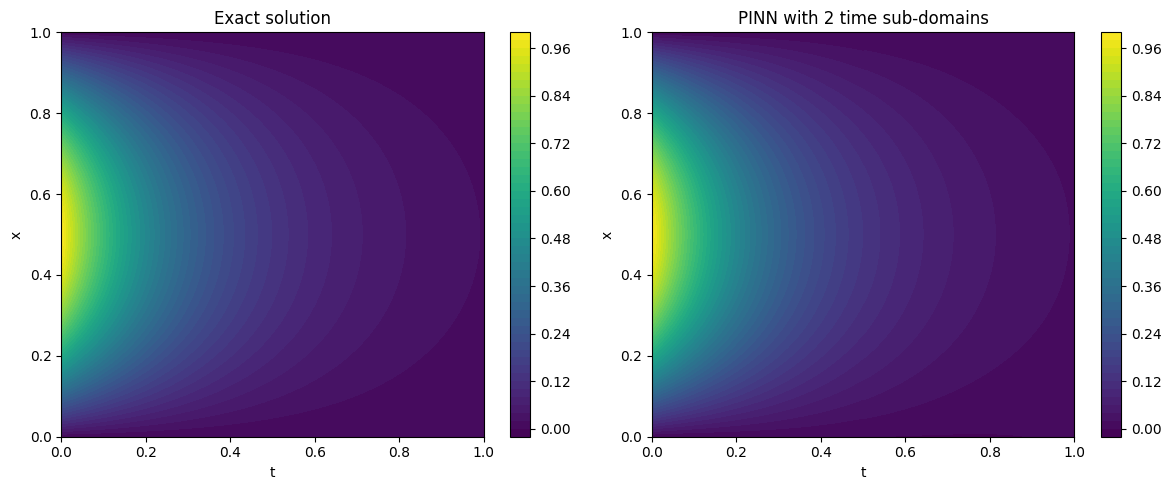

<function matplotlib.pyplot.show(close=None, block=None)>

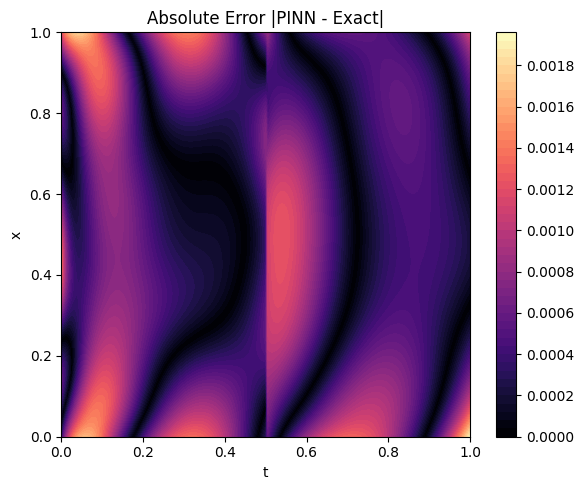

In [17]:
# --- Contour Plot Comparison (x-t plane) ---

# Initialize a figure for the side-by-side comparison plots
fig = plt.figure(figsize=(12, 5))

# Subplot 1: Exact Solution
ax1 = fig.add_subplot(1, 2, 1)

# Create a filled contour plot of the Exact solution (U_exact) on the (t, x) grid
cf = ax1.contourf(T.cpu(), X.cpu(), U_exact, levels=50) 
fig.colorbar(cf, ax=ax1) # Add color bar for magnitude reference
ax1.set_title("Exact solution")
ax1.set_xlabel("t"); ax1.set_ylabel("x") # Set axes labels


# Subplot 2: PINN Prediction
ax2 = fig.add_subplot(1, 2, 2)
# Create a filled contour plot of the PINN prediction (U_pred)
cf2 = ax2.contourf(T.cpu(), X.cpu(), U_pred, levels=50)
fig.colorbar(cf2, ax=ax2) # Add color bar
ax2.set_title("PINN with 2 time sub-domains") # Highlight the domain decomposition approach
ax2.set_xlabel("t"); ax2.set_ylabel("x")

plt.tight_layout() # Adjust layout to prevent overlapping elements
plt.show() # Display the comparison figure


# --- Absolute Error Plot ---
# Calculate the absolute difference between the PINN prediction and the Exact solution
error = np.abs(U_pred - U_exact)

# Initialize a new figure for the error plot
plt.figure(figsize=(6, 5))

# Create a filled contour plot of the absolute error (|PINN - Exact|)
# Use a specific colormap (e.g., 'magma') often suitable for error visualization
cf = plt.contourf(T.cpu(), X.cpu(), error, levels=50, cmap='magma')

plt.colorbar(cf) # Add color bar to show error magnitude
plt.title("Absolute Error |PINN - Exact|")
plt.xlabel("t")
plt.ylabel("x")

plt.tight_layout()
plt.show


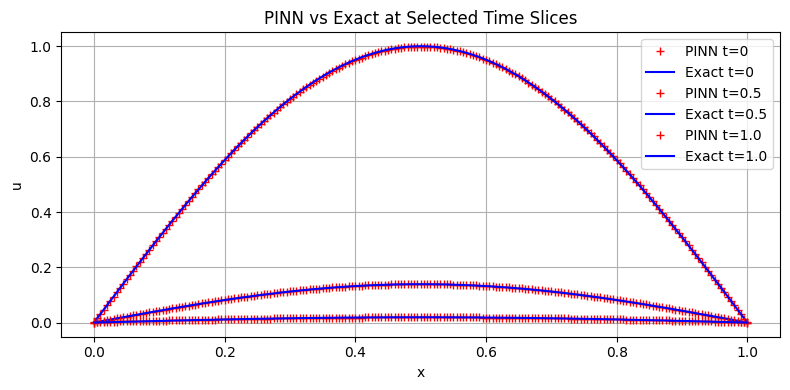

In [19]:
def plot_t_specific(t_val, label):
    """
    Plots the PINN predicted solution u(x, t_val) and the exact solution 
    as a function of x at a fixed time t_val (a 1D cut).
    """
    # Create x-coordinates tensor (Nx, 1) spanning the spatial domain [0, L]
    x = xg.unsqueeze(1)
    
    # Create the time tensor (t) where all elements are fixed at the target time t_val
    t = torch.full_like(x, t_val)
    
    # Disable gradient tracking for efficient prediction
    with torch.no_grad():
        # Select the correct network (net1 or net2) based on the target time t_val relative to t_split.
        # If t_val <= t_split, use net1 (Domain 1). Otherwise, use net2 (Domain 2).
        u_pred = torch.where(t <= t_split,
                             net1(torch.cat((x, t), 1)),  # net1 for the first time domain
                             net2(torch.cat((x, t), 1)))  # net2 for the second time domain
                             
    # Plot the PINN prediction using red markers ('r+')
    plt.plot(x.cpu(), u_pred.cpu(), 'r+', label=f'PINN {label}')
    
    # Plot the Exact solution using a blue solid line ('b-')
    plt.plot(x.cpu(), u_exact(x.cpu().numpy(), np.full_like(x.cpu().numpy(), t_val)),
             'b-', linewidth=1.5, label=f'Exact {label}')


# --- Execution and Visualization ---

# Initialize a new figure for the time slice comparisons
plt.figure(figsize=(8, 4))

# Plot the solution at three distinct time slices (t=0, t=0.5, t=1.0)
plot_t_specific(0.0, 't=0')   # Initial condition comparison
plot_t_specific(0.5, 't=0.5') # Mid-time comparison (Note: If t_split=0.5, this is the interface)
plot_t_specific(1.0, 't=1.0') # Final time comparison

# Add plot metadata
plt.xlabel("x")
plt.ylabel("u")
plt.title("PINN vs Exact at Selected Time Slices")
plt.legend() # Display the labels defined in plot_t_specific
plt.grid(True)
plt.tight_layout()
plt.show()